# Tabling fast

This is the script to create the table of measurements in section 4.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator, LogLocator
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint
import scipy.constants as c
import matplotlib.transforms as mtransforms
import os
from cycler import cycler
from pyphonon import *

# Create a color pallete
colors = cycler(color=['#EF476F','#FFD166','#06D6A0','#118AB2','#073B4C'])
plt.rc('axes', prop_cycle=colors)

# Check for GPU support
try:
    import cupy as cp
    import numpy as np
    GPU = True
    print(bcolors.OKGREEN+'GPU Support Enabled'+bcolors.ENDC)
except ImportError:
    import numpy as np
    GPU = False
    print(bcolors.WARNING+'Cupy Not available in your system. No GPU Support'+bcolors.ENDC)

# Ignore large warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Set some flags and environment variables
data_dir     = './data/'
fluid_dir    = 'fluids/'
particle_dir = 'particles/'

%matplotlib widget

CUDA GPU Acceleration is unavailable for your system : (
Cupy Not available in your system. No GPU Support


In [2]:
# Collect the fluids and particles from the directories
fluid_files     = [data_dir+fluid_dir+f for f in os.listdir(data_dir+fluid_dir)]
fluid_names     = [f.replace('.txt','') for f in os.listdir(data_dir+fluid_dir)]
particle_files  = [data_dir+particle_dir+f for f in os.listdir(data_dir+particle_dir)]
particle_names  = [f.replace('.txt','') for f in os.listdir(data_dir+particle_dir)]
fluids          = [fluid(fname,name=n) for fname,n in zip(fluid_files,fluid_names)] 
particles       = [particle(fname,name=n) for fname,n in zip(particle_files,particle_names)]

In [3]:
# Create an estimator

# Simulator parameters
max_order   = 0
n_cores     = 20
slow        = False

# Create estimator
E = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 0
Assembling the estimator using multiprocessing on 20 cores
Permuations created successfully
	Send the fast data to the pool
CUDA GPU Acceleration is unavailable for your system : (
	Fast: 0, 0 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/1 [00:00<?, ?it/s]

Estimator Generated Successfully


In [4]:
# Create a better estimator

# Simulator parameters
max_order   = 1
n_cores     = 20
slow        = False

# Create estimator
G = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 1
Assembling the estimator using multiprocessing on 20 cores
Permuations created successfully
	Send the fast data to the pool
CUDA GPU Acceleration is unavailable for your system : (
CUDA GPU Acceleration is unavailable for your system : (
CUDA GPU Acceleration is unavailable for your system : (
	Fast: 0, 0 Done!
	Fast: 1, 0 Done!
	Fast: 1, 1 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/3 [00:00<?, ?it/s]

Estimator Generated Successfully


In [5]:
#### HELPER FUNCTIONS #####

# Get the values for multiple fluids
def max_pressure_fluids(r,v,fluids,particle,E=E,G=G,method='nedler-mead',VERBOSE=True):
    # Set the particle's velocity
    particle(v)

    # Arrays to store stuff
    fmax    = []
    pres    = []
    results = []
    
    # For each fluid
    for fluid in tqdm(fluids,disable=not VERBOSE):
        # Get viscosity coefficient
        l = fluid.viscosity_coefficient()*fluid.sound_speed
        V = particle.speed/fluid.sound_speed

        # Find the maximum at zero order
        # fun,x,res = max_pressure_constrained(r,V,l)#,E=E,method=method)
        # fun,x,res = max_pressure(r,V,l,E=E,method=method)
        fun,x,res = max_pressure_single(r,V,l,E=E,method=method,VERBOSE=VERBOSE)

        # Plug it in to the corrected order
        fmax.append(G(r,x[1],x[0],V,l))
        results.append(res)
        pres.append(-fmax[-1]*fluid.energy_deposition(particle))

        # Print some stuff
        if VERBOSE: print(fluid.name + ': %.15e %.15e %.15e Pa'%(fun,fmax[-1],pres[-1])
                            +'\n\tt: %.5e z: %.5e'%(res['x'][0],res['x'][1]))


    return fmax,pres,results

# Calculate the maximum pressure given certain parameters
def max_pressure(r,v,l,E=E,method='nelder-mead',VERBOSE=True):
    # Initial token z position
    z   = 0.1

    # Estimator caller
    p = lambda x: -E(r,x[1],x[0],v,l)

    # Do the optimization
    x0 = np.array([np.sqrt(r**2 + z**2),z])
    res = minimize(p,x0,method=method, options={'xatol': 1e-9, 'disp': True})

    return -res['fun'], res['x'], res

# Calculate the maximum pressure given certain parameters
def max_pressure_single(r,v,l,E=E,method='nelder-mead',VERBOSE=True):
    # Initial token z position
    z   = r/np.sqrt(v**2/(v**2-1))
    # z   = r/np.sqrt(v**2-1)*1e7
    # a=np.sqrt(v**2/(v**2-1))

    # Estimator caller
    p = lambda x: -E(r,z,x[0],v,l)
    # p = lambda x: -E(r,-r*np.sqrt(v**2-1) - a + v*x[0],x[0],v,l)

    # Do the optimization
    x0 = np.array([np.sqrt(r**2 + z**2)])
    # gb = 1/np.sqrt(v**2-1)
    # x0 = np.array([gb**2 * v * (r/gb + a) + gb**2*np.sqrt(a**2+2*a*r/gb)])

    res = minimize(p,x0,method=method, options={'xatol': 1e-9, 'disp': VERBOSE})
    X = list(res['x'])
    X.append(z)
    # X.append(-r*np.sqrt(v**2-1) - a + v*res['x'][0])
    res['x'] = np.array(X)

    return -res['fun'], res['x'], res

# Calculate the maximum pressure given certain parameters and constraints
def max_pressure_constrained(r,v,l,JAC=None,HES=None,E=E):
    # Initial token z position
    z   = 0.1

    # Define constraints
    const   = lambda x: np.array(x[0] - np.sqrt(r**2 + x[1]**2))
    cjac    = lambda x: np.array([1,-x[1]/np.sqrt(r**2 + x[1]**2)])
    chess   = lambda x,v: v[0]*np.array([[0,0],[0,-r**2/np.sqrt(r**2+x[1]**2)**3]])
    
    constraint = NonlinearConstraint(const,0,np.inf,jac=cjac,hess=chess)
    constraint_linear = LinearConstraint([1,-1/v],r*np.sqrt(v**2-1),np.inf)

    # # Get jacobian and hessian estimator
    # if JAC is None:
    #     print('Generating Jacobian')
    #     JAC     = E.get_jacobian()
    # if HES is None:
    #     print('Generating Hessian')
    #     HES     = E.get_hessian()

    # Jacobian and Hessian converters
    jac = lambda x: JAC(r,x[1],x[0],v,l)
    hes = lambda x: HES(r,x[1],x[0],v,l)

    # Estimator caller
    p = lambda x: -E(r,x[1],x[0],v,l)

    # Do the optimization
    print('Starting Optimization')
    x0 = np.array([np.sqrt(r**2 + z**2)+0.0001,0])
    res = minimize(p,x0,method='trust-constr', #jac=jac, hess=hes, 
                    constraints=[constraint_linear], options={'verbose': 1, 'disp': True})

    return -res['fun'], res['x'], res

# Plot the maximum
def plot_max(r,z,t,v,l,E=E,tol=0.01,Npts=10000,fig=None,ax=None,Extras=True,T=None,T_scaled=None,mult=1,label=None):
    # Create a figure
    if fig is None: fig = plt.figure()
    if ax is None:  ax  = fig.add_subplot(111)

    # Get the time and plot everything
    if T is None: T   = np.linspace(t-tol,t+tol,Npts)
    if T_scaled is None: T_scaled = T
    pressure = mult*E(r,z,T,v,l)
    ax.plot(T_scaled,pressure,label=label)
    if Extras:
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.axvline(t,c='k')
        # ax.fill_between(T,0,max(pressure),v*T - (z+r*np.sqrt(v**2-1)) < 0,facecolor='red',alpha=0.1,transform=trans)

    return fig,ax

In [6]:
# Calculate the table

# Pick a velocity
r = 1e-2
v = 0.9*c.c #200*xe.sound_speed/xe.sound_speed
# v = 1.1*fluids[-1].sound_speed

# Calculate the table
fmax, pressure, results = max_pressure_fluids(r,v,fluids,particles[0],method='nelder-mead',E=E,G=G)

  0%|          | 0/5 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: -0.000002
         Iterations: 37
         Function evaluations: 78
H2O: 2.049319046044047e-06 2.052826203996488e-06 1.049924685784100e-17 Pa
	t: 3.32067e-01 z: 1.00000e-02
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 38
         Function evaluations: 79
LAR: 3.908358318707723e-07 3.910978765542753e-07 9.458858351287018e-17 Pa
	t: 5.76614e-01 z: 1.00000e-02
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 81
LXE: 1.628808744579460e-07 1.630048376133937e-07 5.294596114574215e-17 Pa
	t: 7.71875e-01 z: 1.00000e-02
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 39
         Function evaluations: 82
LN2: 3.803927566935618e-07 3.806461434336761e-07 7.732445606039424e-17 Pa
	t: 5.81841e-01 z: 1.00000e-02
Optimization terminated 

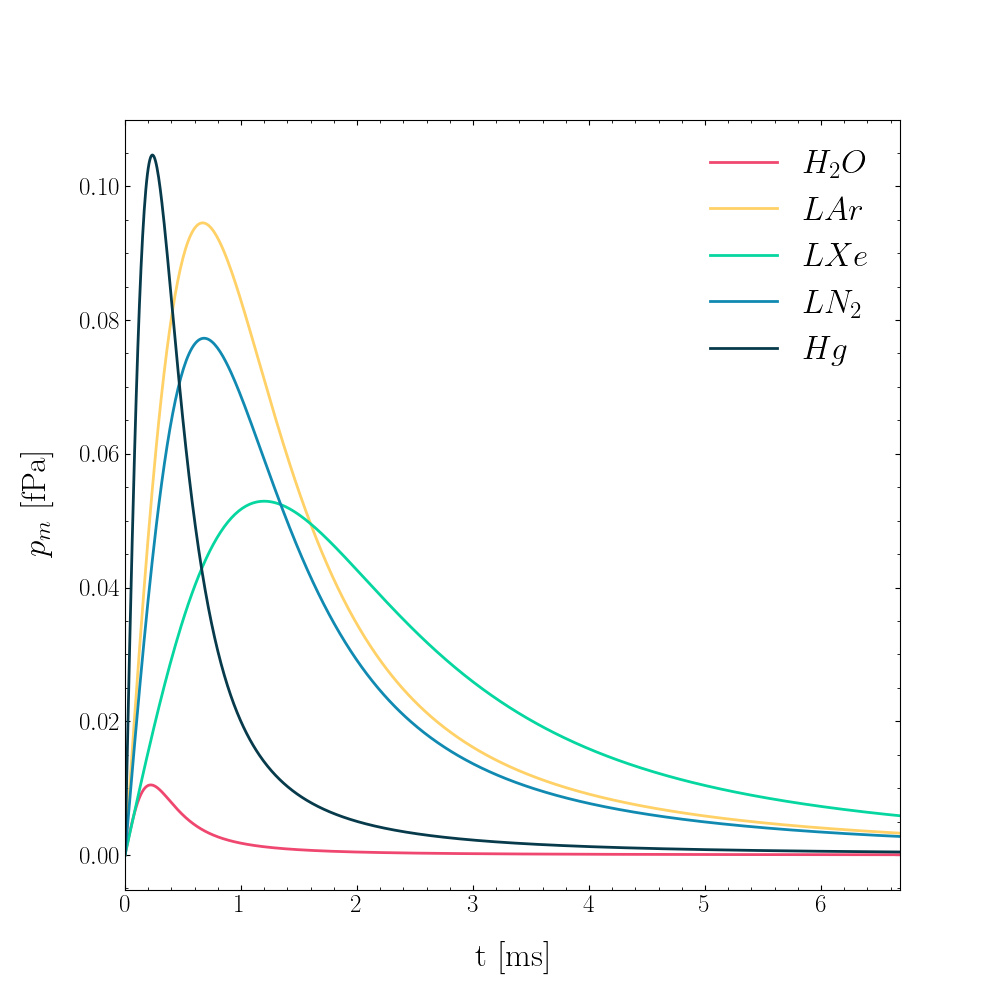

In [7]:
# Finally plot the maxima for the various values
plt.rc('font', family='serif',size=24)
mpl.rc('text', usetex=True)
mpl.rc('legend', fontsize=24)
mpl.rc('ticks')
mpl.rc('lines',linewidth=2)

P = particles[0]
fig = plt.figure(figsize=(10,10),dpi=100)
ax  = fig.add_subplot(111)
Npts = 1000
M_max = 1e1
T   = np.linspace(0,M_max,Npts)
M_max = np.inf

# Change the names of the fluids
names = [r'$H_2 O$',r"$LAr$",r"$LXe$",r"$LN_2$",r"$Hg$"]
for f,n in zip(fluids,names):
    f.name = n

for res,f in zip(results,fluids):
    # Get viscosity coefficient
    l           = f.viscosity_coefficient()*f.sound_speed
    V           = P.speed/f.sound_speed
    T_scaled    = T /f.sound_speed*1e3
    M_max = min(M_max,T_scaled[-1])
    # print(res['x']/f.sound_speed,res['x'])
    plot_max(r,res['x'][1],res['x'][0],V,l,E=E,fig=fig,ax=ax,Extras=False,
                T=T,T_scaled=T_scaled,mult=-f.energy_deposition(P)*1e15,label=f.name)

ax.legend(frameon=False)
ax.tick_params(axis='both',which='both',direction='in',top=True,right=True,labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.grid(axis='both', which='major', lw=0.25)
# ax.grid(axis='both', which='minor', lw=0.2, ls=':')
ax.set_ylabel(r'$p_{m}$ [fPa]',labelpad=18)
ax.set_xlabel('t [ms]',labelpad=18)
ax.set_xlim(min(T_scaled),M_max);

[0.33206736 0.01      ] -2.0493190460440473e-06
[0.57661425 0.01      ] -3.908358318707723e-07
[0.771875 0.01    ] -1.6288087445794596e-07
[0.58184082 0.01      ] -3.8039275669356177e-07
[0.34269248 0.01      ] -1.8643011847647523e-06


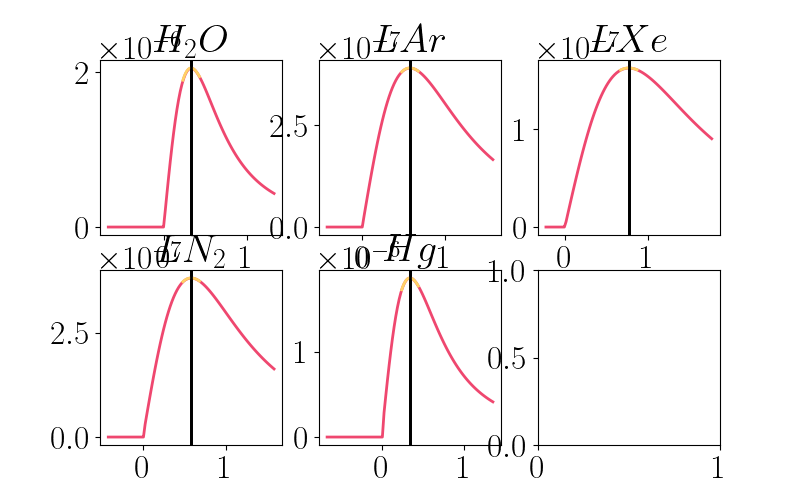

In [8]:
fig,axes = plt.subplots(2,3,figsize=(8,5))
axes=axes.flatten()

for i,f in enumerate(fluids):
    res = results[i]
    l           = f.viscosity_coefficient()*f.sound_speed
    V           = v/f.sound_speed
    plot_max(r,res['x'][1],res['x'][0],V,l,E=E,Npts=100,tol=1,Extras=True,fig=fig,ax=axes[i])
    axes[i].set_title(f.name)
    plot_max(r,res['x'][1],res['x'][0],V,l,E=G,Npts=100,tol=.1,Extras=True,fig=fig,ax=axes[i])
    print(res['x'],res['fun'])

  0%|          | 0/100 [00:00<?, ?it/s]

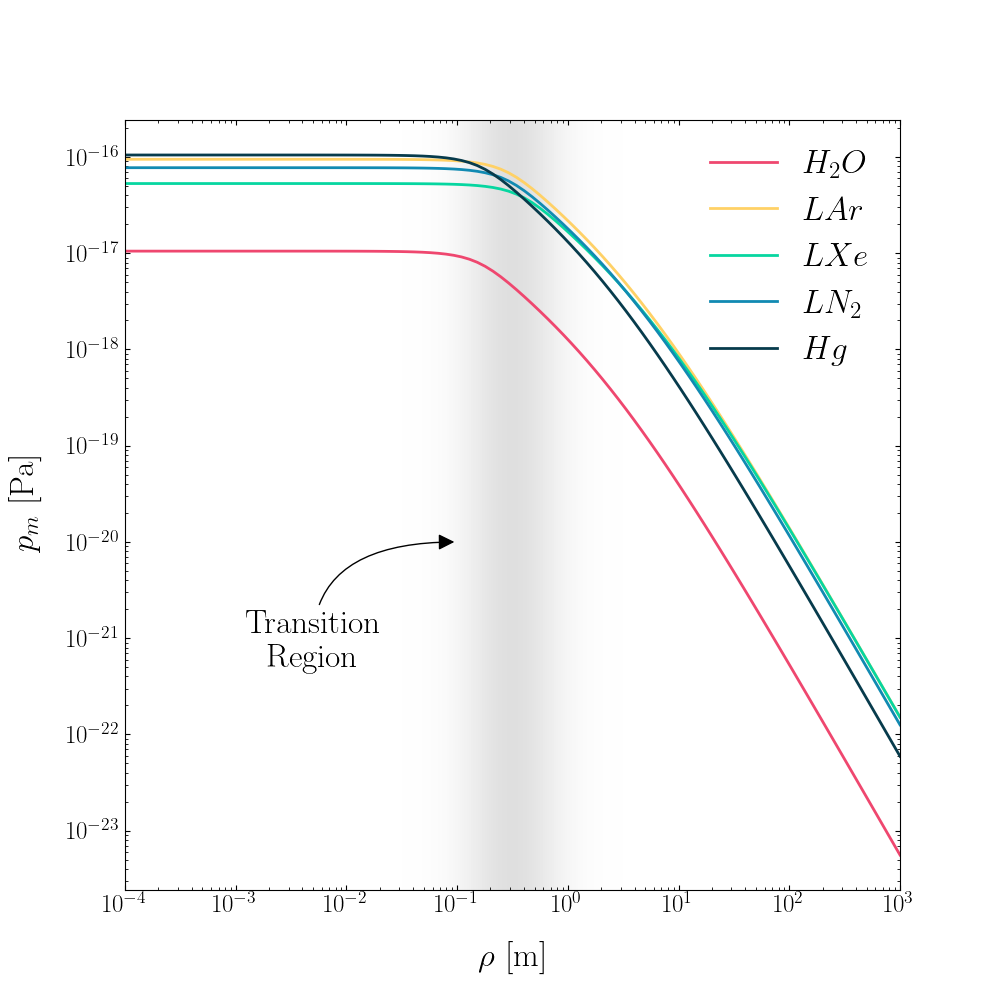

In [9]:
# Plot peak pressure as a function of radius
R = 10.**np.linspace(-4,3,100)

Ps = []

# Calculate the pressures
for r in tqdm(R):
    fmax, pressure, results = max_pressure_fluids(r,v,fluids,particles[0],method='nelder-mead',E=E,G=G,VERBOSE=False)
    Ps.append(pressure)
Ps = np.array(Ps).T

# Create the figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax  = fig.add_subplot(111)

# Plot the Pressure
for i,p in enumerate(Ps):
    ax.plot(R,p,label=fluids[i].name)

# Add the middle indicator
xlim    = (-1.5,0.5)
Npts    = 100
xpoints = 10**np.linspace(*xlim,Npts)
alpha   = np.linspace(-1,1,Npts-1)
alphas  = 0.5*np.exp(-5*alpha**2)

for i in range(len(alphas)):
    ax.axvspan(xpoints[i],xpoints[i+1],color='silver',alpha=alphas[i],ls='',lw=0)


ax.annotate('Transition\nRegion',xy=(1e-1,1e-20),xycoords='data',horizontalalignment='center',
            xytext=(5e-3,5e-22),textcoords='data',fontsize=24,
            arrowprops=dict(arrowstyle='-|>',color='k',connectionstyle="angle3"),c='k')


# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=False)
ax.set_xlim(min(R),max(R))
ax.tick_params(axis='both',which='both',direction='in',top=True,right=True,labelsize=18)
ax.xaxis.set_minor_locator(LogLocator(base=10.,subs='all'))
# ax.grid(axis='both', which='major', lw=0.25)
# ax.grid(axis='both', which='minor', lw=0.2, ls=':')
ax.set_xlabel(r'$\rho$ [m]',labelpad=18)
ax.set_ylabel(r'$p_m$ [Pa]',labelpad=18);

  0%|          | 0/100 [00:00<?, ?it/s]

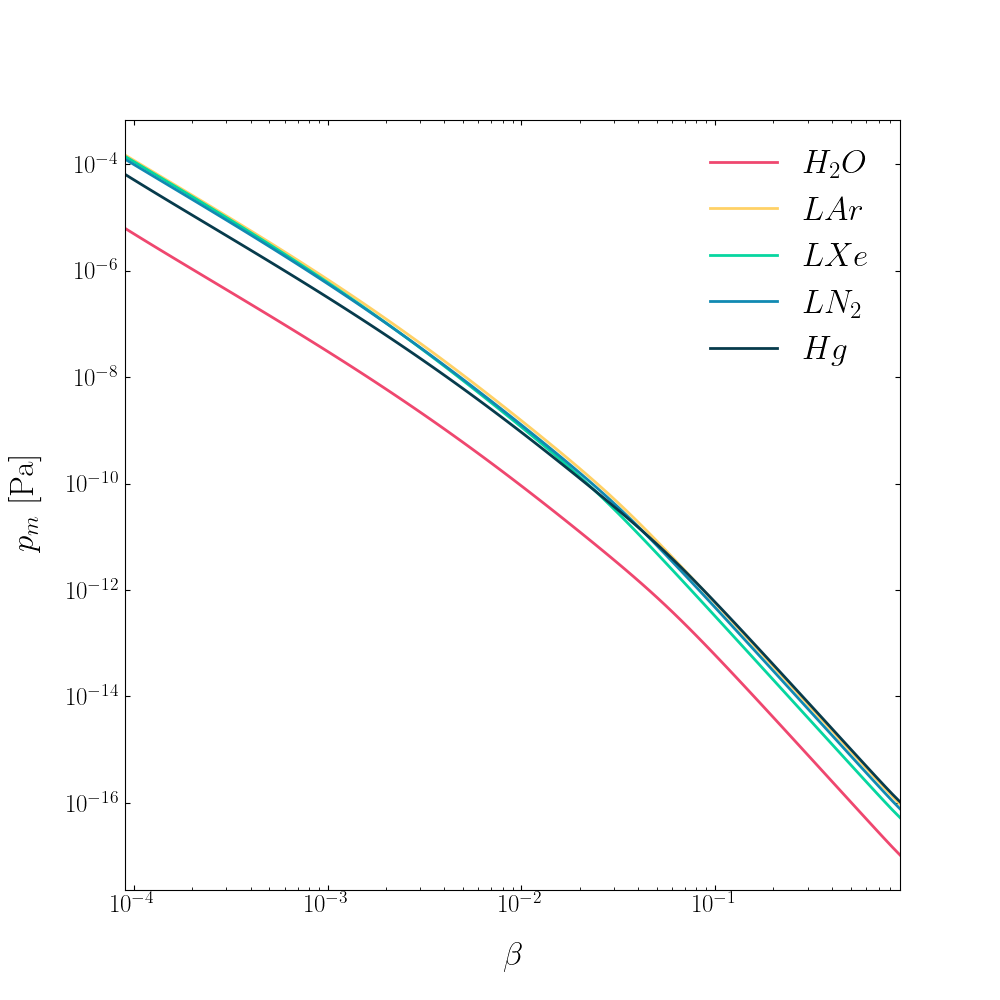

In [10]:
# Plot peak pressure as a function of velocity
V = 10.**np.linspace(-5,-1,100) * 9 * c.c 
r = 1e-2
Ps = []

# Calculate the pressures
for v in tqdm(V):
    fmax, pressure, results = max_pressure_fluids(r,v,fluids,particles[0],method='nelder-mead',E=E,G=G,VERBOSE=False)
    Ps.append(pressure)
Ps = np.array(Ps).T

# Create the figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax  = fig.add_subplot(111)

# Plot the Pressure
for i,p in enumerate(Ps):
    ax.plot(V/c.c,p,label=fluids[i].name)

# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=False)
ax.set_xlim(min(V/c.c),max(V/c.c))
ax.tick_params(axis='both',which='major',direction='in',top=True,right=True,labelsize=18)
ax.tick_params(axis='both',which='minor',direction='in',top=True,right=True,labelsize=0)
ax.xaxis.set_minor_locator(LogLocator(base=10.,subs='all'))
# ax.grid(axis='both', which='major', lw=0.25)
# ax.grid(axis='both', which='minor', lw=0.2, ls=':')
ax.set_xlabel(r'$\beta$',labelpad=18)
ax.set_ylabel(r'$p_m$ [Pa]',labelpad=18);

In [11]:
# Plot peak pressure as a function of velocity

Temperatures = [298.15,84,165,77,298.15]
Names        = ['Water','Argon','Xenon','Nitrogen','Mercury']

for t,f,n in zip(Temperatures,fluids,Names):
    # print("%3s: %6.2f %8.2f %7.2f %8.5f %7.5f %6.2f" % (n,t,f.rest_density,f.sound_speed,f.viscosity*1e4, f.thermal_expansion/f.specific_heat*1e6,f.mean_excitation_energy/c.eV))
    print("%10s & %6.2f & %8.2f & %7.2f & %8.5f & %7.5f & %6.2f\\\\" % (n,t,f.rest_density,f.sound_speed,f.viscosity*1e4, f.thermal_expansion/f.specific_heat*1e6,f.mean_excitation_energy/c.eV))

     Water & 298.15 &   997.02 & 1496.60 &  8.90030 & 0.06122 &  79.70\\
     Argon &  84.00 &  1415.67 &  861.24 &  2.88490 & 3.98389 & 188.00\\
     Xenon & 165.00 &  2942.40 &  643.27 &  5.10420 & 6.66136 & 482.00\\
  Nitrogen &  77.00 &   807.20 &  853.50 &  1.61980 & 2.72482 &  82.00\\
   Mercury & 298.15 & 13600.00 & 1450.10 & 16.85000 & 1.27989 & 799.97\\
